<a href="https://colab.research.google.com/github/kritiayush11/Oxford-Flowers102-Classification-System/blob/main/level_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### IMPORT Libraries

In [18]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [19]:
img_height, img_width = 180, 180
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

### DATA LOAD

In [20]:
(train_raw, val_raw), info = tfds.load(
    "oxford_flowers102",
    split=["train", "validation"],
    as_supervised=True,
    with_info=True
)

class_names = info.features["label"].names
num_classes = info.features["label"].num_classes
print("Classes:", num_classes)

Classes: 102


###PREPROCESSING (Resize + Batch + Prefetch)

In [21]:
def preprocess(image, label):
    image = tf.image.resize(image, (img_height, img_width))
    return image, label

train_ds = train_raw.map(preprocess, num_parallel_calls=AUTOTUNE).batch(batch_size).prefetch(AUTOTUNE)
val_ds   = val_raw.map(preprocess, num_parallel_calls=AUTOTUNE).batch(batch_size).prefetch(AUTOTUNE)

### VISUALISE DATA

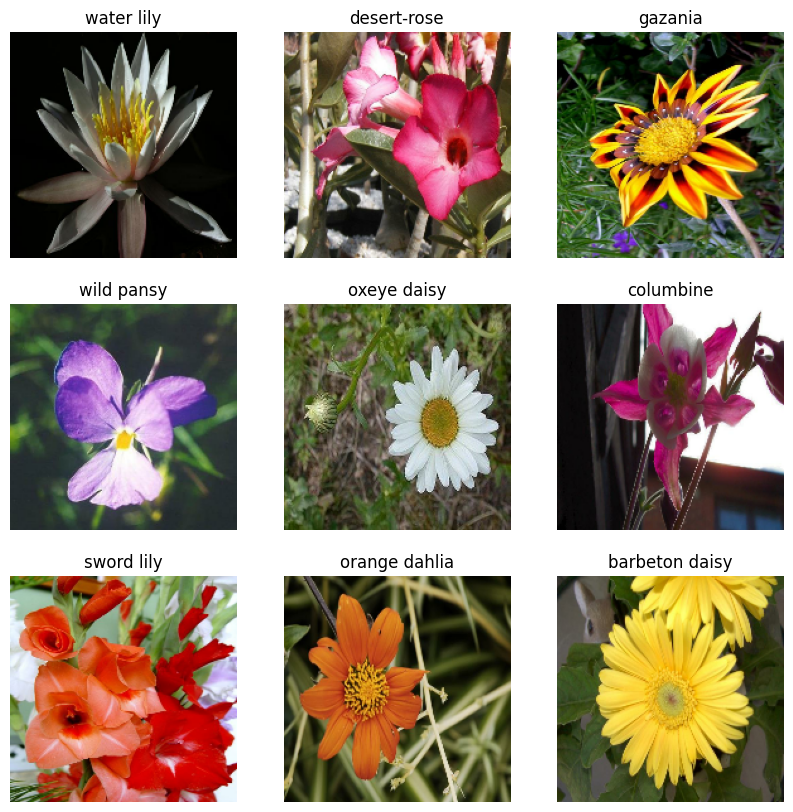

In [22]:
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[int(labels[i])])
        plt.axis("off")
plt.show()


###BUILD BASELINE MODEL (ResNet50 Transfer Learning)

In [23]:
preprocess_input = tf.keras.applications.resnet50.preprocess_input

base_model = tf.keras.applications.ResNet50(
    include_top=False,
    input_shape=(img_height, img_width, 3),
    weights="imagenet"
)

base_model.trainable = False  # freeze pretrained layers

baseline_model = Sequential([
    layers.Input(shape=(img_height, img_width, 3)),
    layers.Lambda(preprocess_input),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation="softmax")
])

baseline_model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda_1 (Lambda)               │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 6, 6, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 102)            │        26,214 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,138,470 (92.08 MB)

 Trainable params: 550,758 (2.10 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [24]:
baseline_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


In [25]:
epochs_level1 = 10

history_level1 = baseline_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs_level1
)

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 289s 9s/step - accuracy: 0.0421 - loss: 4.8485 - val_accuracy: 0.3314 - val_loss: 3.4448
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 238s 8s/step - accuracy: 0.3722 - loss: 2.8103 - val_accuracy: 0.5520 - val_loss: 2.1059
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 259s 7s/step - accuracy: 0.6297 - loss: 1.6248 - val_accuracy: 0.6588 - val_loss: 1.4603
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 232s 7s/step - accuracy: 0.7627 - loss: 0.9823 - val_accuracy: 0.7206 - val_loss: 1.1813
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 257s 8s/step - accuracy: 0.8414 - loss: 0.6865 - val_accuracy: 0.7569 - val_loss: 1.0391
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 261s 8s/step - accuracy: 0.8700 - loss: 0.5207 - val_accuracy: 0.7637 - val_loss: 0.9265
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 230s 7s/step - accuracy: 0.9235 - loss: 0.3398 - val_accuracy: 0.7980 - val_loss: 0.8449
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 234s 7s/step - accuracy: 0.9489 - loss: 0.2487 - val_accuracy: 0.7990 - v

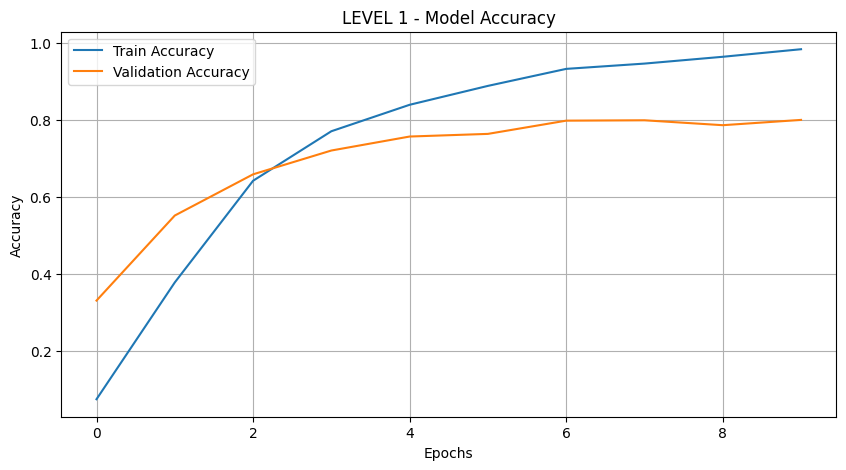

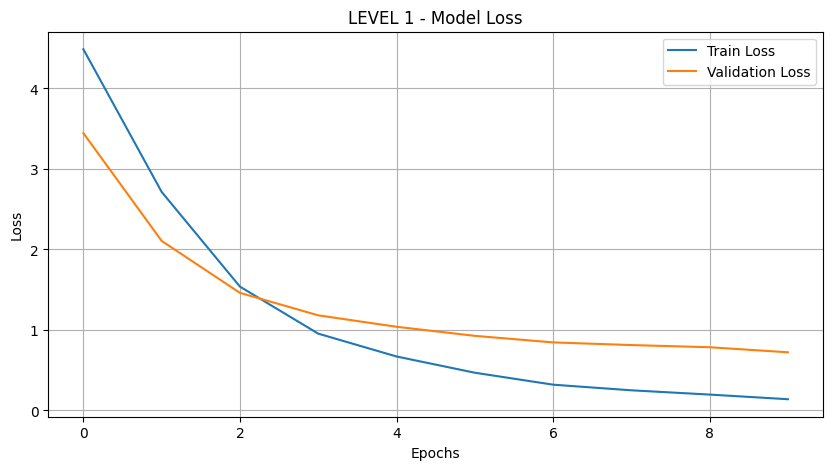

In [26]:
plt.figure(figsize=(10,5))
plt.plot(history_level1.history['accuracy'], label='Train Accuracy')
plt.plot(history_level1.history['val_accuracy'], label='Validation Accuracy')
plt.title("LEVEL 1 - Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(history_level1.history['loss'], label='Train Loss')
plt.plot(history_level1.history['val_loss'], label='Validation Loss')
plt.title("LEVEL 1 - Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

In [28]:
test_raw = tfds.load(
    "oxford_flowers102",
    split="test",
    as_supervised=True
)

#  Preprocess test dataset
test_ds = test_raw.map(preprocess, num_parallel_calls=AUTOTUNE)\
                  .batch(batch_size)\
                  .prefetch(AUTOTUNE)

In [29]:
test_loss_1, test_acc_1 = baseline_model.evaluate(test_ds)
print(" LEVEL 1 TEST ACCURACY:", test_acc_1)

193/193 ━━━━━━━━━━━━━━━━━━━━ 688s 4s/step - accuracy: 0.7850 - loss: 0.8564
 LEVEL 1 TEST ACCURACY: 0.7872824668884277


In [ ]:
base_model.trainable = True

for layer in base_model.layers[:-50]:
    layer.trainable = False

baseline_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history_ft = baseline_model.fit(train_ds, validation_data=val_ds, epochs=10)

test_loss_1, test_acc_1 = baseline_model.evaluate(test_ds)
print(" LEVEL 1 (After Fine-Tuning) TEST ACCURACY:", test_acc_1)


Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 385s 11s/step - accuracy: 0.7268 - loss: 0.9966 - val_accuracy: 0.8020 - val_loss: 0.7300
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 358s 11s/step - accuracy: 0.9069 - loss: 0.4097 - val_accuracy: 0.8078 - val_loss: 0.7501
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.9539 - loss: 0.2555